In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from typing import Dict
import matplotlib.pyplot as plt

from arch import arch_model
import garch_model

# 1. Processing Market Data

In [2]:
# Home Path
BASE_PATH = Path("C:/Users/helen/OneDrive/Desktop/GSB - MSQF/2025 Fall/Blockchain, Cryptocurrency, and Algorithmic Trading/data")

# Target Coins
ALL_SYMBOLS = ["BTCUSDT", "ETHUSDT"]

# Data Types
CORE_DATA_TYPES = ["trade_1min", "level1_1min", "book_1min", "openinterest_1min"]
# optional: if we can get liquidation data later it's ok to add it.
INCLUDE_LIQUIDATION = False
if INCLUDE_LIQUIDATION:
    DATA_TYPES = CORE_DATA_TYPES + ["liquidation_1min"]
else:
    DATA_TYPES = CORE_DATA_TYPES

TYPE_PREFIX = {
    "trade_1min": "tr",   # trade
    "level1_1min": "l1",  # L1 order book
    "book_1min":   "l2",  # L2 order book
    "openinterest_1min": "oi",  # open interest
    "liquidation_1min": "liq",  # no data but with integral structure
}

In [3]:
def load_one_type_symbol(base_path: Path, data_type: str, symbol: str, prefix: str):
    """
    Read all 1-minute files for a given symbol (e.g., 'BTCUSDT') under a given data_type (e.g., 'trade_1min').
    Perform basic cleaning and prefix the columns.
    - If the directory does not exist/there are no files, return None and print a [WARN].
    - ts_end: Treats as millisecond-level timestamps → converts to UTC datetime and sets it as the index.
    """
    folder = base_path / data_type / symbol
    if not folder.exists():
        print(f"[WARN] Folder not found: {folder}")
        return None

    files = sorted(folder.glob("*.csv.gz"))
    if not files:
        print(f"[WARN] No files in {folder}")
        return None

    dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] Failed to read {f}: {e}")

    if not dfs:
        print(f"[WARN] No valid dataframes for {data_type} / {symbol}")
        return None

    df = pd.concat(dfs, ignore_index=True)

    # Timestamp processing: Server data is ts_end in ms
    if "ts_end" not in df.columns:
        print(f"[WARN] ts_end missing in {data_type} / {symbol}, columns={df.columns.tolist()}")
        return None

    df["ts_end"] = pd.to_datetime(df["ts_end"], unit="ms", utc=True)
    df = df.sort_values("ts_end").set_index("ts_end")

    # Remove duplicate timestamps (keep the last one).
    df = df[~df.index.duplicated(keep="last")]

    # Add a prefix to all columns to avoid column name conflicts during subsequent joins.
    col_map = {col: f"{prefix}__{col}" for col in df.columns}
    df = df.rename(columns=col_map)

    return df


In [ ]:
def build_combined_symbol_df(base_path: Path,
                             symbol: str,
                             data_types=DATA_TYPES,
                             type_prefix_map=TYPE_PREFIX):
    """
    For a given symbol (e.g., 'BTCUSDT'), load all specified data types,
    and perform an outer join based on the time index to obtain a complete 1-minute data table.
    - Note: openinterest_1min currently only has data for 2024;
    For the 2023 time period, the corresponding oi__* columns will naturally all be NaN → this is normal and acceptable.
    - liquidation_1min is not loaded by default because this directory is empty on the server.
    """
    dfs = []
    for dt in data_types:
        prefix = type_prefix_map.get(dt, dt)
        df = load_one_type_symbol(base_path, dt, symbol, prefix)
        if df is not None and not df.empty:
            dfs.append(df)
        else:
            print(f"[INFO] Skip empty {dt} for {symbol}")

    if not dfs:
        print(f"[ERROR] No data loaded at all for {symbol}")
        return None

    combined = dfs[0]
    for df in dfs[1:]:
        # Outer join indexed by time, not mandatory to include all elements
        combined = combined.join(df, how="outer")

    # Sort by time again, just to be on the safe side.
    combined = combined.sort_index()

    return combined

In [5]:
combined_data = {}
MONARQ_PATH = BASE_PATH / "monarq_data"

for sym in ALL_SYMBOLS:
    print(f"\n=== Building combined df for {sym} ===")
    df = build_combined_symbol_df(MONARQ_PATH, sym)
    if df is not None:
        combined_data[sym] = df
        print(f"{sym}: shape = {df.shape}")
    else:
        print(f"[WARN] No combined df for {sym}")


=== Building combined df for BTCUSDT ===
BTCUSDT: shape = (1052641, 113)

=== Building combined df for ETHUSDT ===
ETHUSDT: shape = (1052641, 113)


# 2. Processing Funding Rates

In [6]:
funding_data_path = BASE_PATH / "binance_rates"
files = glob.glob(os.path.join(funding_data_path, "BNBUSDT*.csv.gz"))

print("Number of files found:", len(files))

df_list = []
for f in sorted(files):
    tmp = pd.read_csv(f)
    tmp['source_file'] = f   # optional: Keep source files
    df_list.append(tmp)

bnb_rates = pd.concat(df_list, ignore_index=True)

bnb_rates.head()

Number of files found: 731


,ts,rate,interval,next_ts,next_rate,dt,source_file
0,1.672531e+12,-0.000010,NaN,1.672560e+12,NaN,2023-01-01 00:00:00,C:\Users\helen\OneDrive\Desktop\GSB - MSQF\202...
1,1.672535e+12,-0.000032,NaN,1.672560e+12,NaN,2023-01-01 01:00:00,C:\Users\helen\OneDrive\Desktop\GSB - MSQF\202...
2,1.672538e+12,-0.000040,NaN,1.672560e+12,NaN,2023-01-01 02:00:00,C:\Users\helen\OneDrive\Desktop\GSB - MSQF\202...
3,1.672542e+12,-0.000017,NaN,1.672560e+12,NaN,2023-01-01 03:00:00,C:\Users\helen\OneDrive\Desktop\GSB - MSQF\202...
4,1.672546e+12,0.000000,NaN,1.672560e+12,NaN,2023-01-01 04:00:00,C:\Users\helen\OneDrive\Desktop\GSB - MSQF\202...


In [7]:
def load_symbol_rates(symbol: str, base_path: str) -> pd.DataFrame:
    """
    Read all rates_light.csv.gz files for a given symbol,
    and return a normalized DataFrame: ['ts', 'dt', 'rate'], sorted by time.
    """
    pattern = os.path.join(base_path, f"{symbol}*.rates_light.csv.gz")
    files = sorted(glob.glob(pattern))
    
    if not files:
        raise FileNotFoundError(f"No files found for {symbol} with pattern: {pattern}")
    
    df_list = []
    for f in files:
        tmp = pd.read_csv(f)
        
        # Standardized column names: ts (timestamp in milliseconds), rate (funding rate)
        cols = {c.lower(): c for c in tmp.columns}  # Lowercase mapping to the original column name
        
        # Try to find the timestamp column
        if "ts" in cols:
            ts_col = cols["ts"]
        elif "timestamp" in cols:
            ts_col = cols["timestamp"]
        elif "fundingtime" in cols:
            ts_col = cols["fundingtime"]
        else:
            raise KeyError(f"Cannot find a timestamp column in {f}, columns: {tmp.columns}")
        
        # Try to find the rate column
        if "rate" in cols:
            rate_col = cols["rate"]
        elif "fundingrate" in cols:
            rate_col = cols["fundingrate"]
        else:
            raise KeyError(f"Cannot find a rate column in {f}, columns: {tmp.columns}")
        
        # Keep only the columns you need
        tmp = tmp[[ts_col, rate_col]].copy()
        tmp.columns = ["ts", "rate"]
        
        # The time signature (ts) might be read in as a float, converted to an integer, and then converted to time.
        tmp["ts"] = tmp["ts"].astype("int64")
        tmp["dt"] = pd.to_datetime(tmp["ts"], unit="ms", utc=True)
        
        # Adding a symbol field makes merging easier later.
        tmp["symbol"] = symbol
        
        df_list.append(tmp)
    
    df = pd.concat(df_list, ignore_index=True)
    df = df.sort_values("dt").drop_duplicates(subset=["dt"])  # 按时间排序 & 去重
    return df[["ts", "dt", "symbol", "rate"]]


# ========= 3. Read 5 coins in batch and get a dictionary + panel table.==========

def load_all_funding_rates(symbols, base_path):
    """
    return :
      rates_dict: {symbol -> df(ts, dt, symbol, rate)}
      panel_df: large df, index=dt, columns=symbol, values=rate
    """
    rates_dict = {}
    all_list = []
    
    for sym in symbols:
        df = load_symbol_rates(sym, base_path)
        rates_dict[sym] = df
        all_list.append(df)
    
    long_df = pd.concat(all_list, ignore_index=True)
    
    # Wide table: Each row contains a timestamp, and each column contains a symbol representing the funding rate.
    panel_df = long_df.pivot(index="dt", columns="symbol", values="rate").sort_index()
    
    return rates_dict, panel_df

In [8]:
rates_dict, panel_rates = load_all_funding_rates(ALL_SYMBOLS, funding_data_path)

for s in ALL_SYMBOLS:
    print(f"\n=== {s} ===")
    print(rates_dict[s].head())

print("\nPanel wide table (first 5 rows):")
print(panel_rates.head())


=== BTCUSDT ===
                  ts                        dt   symbol    rate
0      1672531200000 2023-01-01 00:00:00+00:00  BTCUSDT  0.0001
15274  1672534800000 2023-01-01 01:00:00+00:00  BTCUSDT  0.0000
2      1672538400000 2023-01-01 02:00:00+00:00  BTCUSDT  0.0001
3      1672542000000 2023-01-01 03:00:00+00:00  BTCUSDT  0.0001
15277  1672545600000 2023-01-01 04:00:00+00:00  BTCUSDT  0.0000

=== ETHUSDT ===
                  ts                        dt   symbol    rate
0      1672531200000 2023-01-01 00:00:00+00:00  ETHUSDT  0.0001
15443  1672534800000 2023-01-01 01:00:00+00:00  ETHUSDT  0.0000
2      1672538400000 2023-01-01 02:00:00+00:00  ETHUSDT  0.0001
3      1672542000000 2023-01-01 03:00:00+00:00  ETHUSDT  0.0001
15446  1672545600000 2023-01-01 04:00:00+00:00  ETHUSDT  0.0000

Panel wide table (first 5 rows):
symbol                     BTCUSDT  ETHUSDT
dt                                         
2023-01-01 00:00:00+00:00   0.0001   0.0001
2023-01-01 01:00:00+00:00   0.00

# 3. Feature Engineering

In [9]:
def rebuild_all_pdf_features(
    combined_data_clean: dict,
    base_symbol: str = "BTCUSDT"
) -> dict:
    """
    Reconstructs all necessary features (excluding sentiment) from the PDF using `combined_data_clean`.

    Assumptions:
    - The index of each data frame is `ts_end` (datetime, UTC).
    - The original microstructure columns `tr__*`, `l1__*`, `l2__*`, `oi__*`, `OFI_raw`, `rv_fwd_*`, etc., already exist.

    Parameters:
    `combined_data_clean`: {symbol -> DataFrame}
    `funding_long`: Optional; must have at least `['dt', 'symbol', 'funding_rate']`, where `dt` is the minute-based UTC value.
    `base_symbol`: The base currency for the cross-asset, defaults to 'BTCUSDT'.

    Returns:
    `combined_data_full`: {symbol -> DataFrame}, containing all features.
    """

    eps = 1e-8
    combined_out = {}

    # ---------- 0. Prepare the datasheet for base_symbol for cross-asset. ----------
    if base_symbol not in combined_data_clean:
        raise KeyError(f"base_symbol '{base_symbol}' not in combined_data_clean")

    # First, process the basic fields of base_df (ret_1m, rv_30m, etc.), then use them for cross-asset processing.
    def _prepare_base_df(df_base: pd.DataFrame) -> pd.DataFrame:
        dfb = df_base.copy()

    # index -> dt, symbol
        if "dt" not in dfb.columns:
            dfb["dt"] = pd.to_datetime(dfb.index)
        if "symbol" not in dfb.columns:
            pass  # 

    # ===== Add OFI_raw logic here. =====
        if "OFI_raw" not in dfb.columns:
            if {"tr__buy_volume", "tr__sell_volume"}.issubset(dfb.columns):
                dfb["OFI_raw"] = dfb["tr__buy_volume"] - dfb["tr__sell_volume"]
            else:
                print("⚠ base df don't have buy/sell volume，can't get OFI_raw")
                dfb["OFI_raw"] = np.nan

    # ret_1m
        if "ret_1m" not in dfb.columns:
            if "tr__close_price" in dfb.columns:
                dfb["ret_1m"] = dfb["tr__close_price"].pct_change()
            else:
                print("⚠ base df don't have tr__close_price, can't get ret_1m")
                dfb["ret_1m"] = np.nan

    # rv_30m
        if "rv_30m" not in dfb.columns:
            if "ret_1m" in dfb.columns:
                dfb["rv_30m"] = (
                    dfb["ret_1m"].pow(2)
                    .rolling(window=30, min_periods=10)
                    .sum()
                )
            else:
                print("⚠ base df don't have ret_1m，can't get rv_30m")
                dfb["rv_30m"] = np.nan

        return dfb


    base_df_raw = combined_data_clean[base_symbol]
    base_df = _prepare_base_df(base_df_raw)

    # Note: The symbol name is not yet known in base_df, but since the cross-asset is only aligned by time, base_df["symbol"] will not be used later.

    # ---------- 2. Build all features for each symbol ----------
    for sym, df0 in combined_data_clean.items():
        print(f"\n=== Rebuilding features for {sym} ===")

        df = df0.copy()

        # 2.1 Basics: index -> dt, symbol
        if "dt" not in df.columns:
            df["dt"] = pd.to_datetime(df.index)
        df["dt"] = pd.to_datetime(df["dt"], utc=True)

        if "symbol" not in df.columns:
            df["symbol"] = sym
        else:
            df["symbol"] = df["symbol"].fillna(sym)

        # 2.2 ret_1m & rv_30m
        if "ret_1m" not in df.columns:
            if "tr__close_price" in df.columns:
                df["ret_1m"] = df["tr__close_price"].pct_change()
            else:
                print("⚠ no tr__close_price，can't get ret_1m")
                df["ret_1m"] = np.nan

        if "rv_30m" not in df.columns:
            if "ret_1m" in df.columns:
                df["rv_30m"] = (
                    df["ret_1m"].pow(2)
                    .rolling(window=30, min_periods=10)
                    .sum()
                )
            else:
                print("⚠ no ret_1m，can't get rv_30m")
                df["rv_30m"] = np.nan

        # ---------- 3. Basic / Interaction / Derived PDF Features ----------

                # 2.x If OFI_raw is not available, construct one using the volume difference.
        if "OFI_raw" not in df.columns:
            if {"tr__buy_volume", "tr__sell_volume"}.issubset(df.columns):
                df["OFI_raw"] = df["tr__buy_volume"] - df["tr__sell_volume"]
            else:
                print(f"⚠ {sym} no buy/sell volume，can't get OFI_raw")
                df["OFI_raw"] = np.nan
        
        
        # 3.1 L1_Imbalance
        if {"l1__close_bid_size", "l1__close_ask_size"}.issubset(df.columns):
            bid_sz = df["l1__close_bid_size"]
            ask_sz = df["l1__close_ask_size"]
            df["L1_Imbalance"] = (bid_sz - ask_sz) / (bid_sz + ask_sz + eps)
        else:
            df["L1_Imbalance"] = np.nan

        # 3.2 VWAP_deviation
        if {"tr__vwap", "tr__close_price"}.issubset(df.columns):
            df["VWAP_deviation"] = (df["tr__vwap"] - df["tr__close_price"]) / (df["tr__close_price"] + eps)
        else:
            df["VWAP_deviation"] = np.nan

        # 3.3 VPIN_proxy
        if {"tr__buy_volume", "tr__sell_volume"}.issubset(df.columns):
            buy_v = df["tr__buy_volume"]
            sell_v = df["tr__sell_volume"]
            df["VPIN_proxy"] = (buy_v - sell_v).abs() / (buy_v + sell_v + eps)
        else:
            df["VPIN_proxy"] = np.nan

        # 3.4 Trade_Intensity
        if "tr__trade_count" in df.columns:
            df["Trade_Intensity"] = df["tr__trade_count"].astype(float)
        else:
            df["Trade_Intensity"] = np.nan

        # 3.5 Liquidity_Weighted_OFI
        if {"OFI_raw", "l1__mean_bid_size", "l1__mean_ask_size"}.issubset(df.columns):
            depth = df["l1__mean_bid_size"] + df["l1__mean_ask_size"]
            df["Liquidity_Weighted_OFI"] = df["OFI_raw"] * depth
        else:
            df["Liquidity_Weighted_OFI"] = np.nan

        # 3.6 Mean_Spread
        if "l1__mean_spread" in df.columns:
            df["Mean_Spread"] = df["l1__mean_spread"]
        else:
            df["Mean_Spread"] = np.nan

        # 3.7 OFI_std_30m
        if "OFI_raw" in df.columns:
            df["OFI_std_30m"] = (
                df["OFI_raw"]
                .rolling(window=30, min_periods=10)
                .std()
            )
        else:
            df["OFI_std_30m"] = np.nan

        # 3.8 Spread_ma_15m
        if "l1__mean_spread" in df.columns:
            df["Spread_ma_15m"] = (
                df["l1__mean_spread"]
                .rolling(window=15, min_periods=5)
                .mean()
            )
        else:
            df["Spread_ma_15m"] = np.nan

        # 3.9 OFI_roc_10m
        if "OFI_raw" in df.columns:
            ofi = df["OFI_raw"]
            ofi_lag10 = ofi.shift(10)
            df["OFI_roc_10m"] = (ofi - ofi_lag10) / (ofi_lag10.abs() + eps)
        else:
            df["OFI_roc_10m"] = np.nan

        # 3.10 Price_Impact_per_Volume
        if {"tr__close_price", "tr__volume"}.issubset(df.columns):
            ret_15m = df["tr__close_price"].pct_change(15)
            vol_15m = (
                df["tr__volume"]
                .rolling(window=15, min_periods=5)
                .sum()
            )
            df["Price_Impact_per_Volume"] = ret_15m.abs() / (vol_15m + eps)
        else:
            df["Price_Impact_per_Volume"] = np.nan

        # ---------- 4. L2 related large order depth & imbalance ----------

        needed_l2 = {
            "l2__bid_10000K_fill_dsize", "l2__ask_10000K_fill_dsize",
            "l2__bid_100000K_fill_dsize", "l2__ask_100000K_fill_dsize",
        }
        if needed_l2.issubset(df.columns):
            df["depth_ratio_10M"] = (
                df["l2__bid_10000K_fill_dsize"] /
                (df["l2__ask_10000K_fill_dsize"] + eps)
            )
            df["depth_ratio_100M"] = (
                df["l2__bid_100000K_fill_dsize"] /
                (df["l2__ask_100000K_fill_dsize"] + eps)
            )
            df["l2_imbalance_10M"] = (
                df["l2__bid_10000K_fill_dsize"] - df["l2__ask_10000K_fill_dsize"]
            ) / (
                df["l2__bid_10000K_fill_dsize"] + df["l2__ask_10000K_fill_dsize"] + eps
            )
        else:
            df["depth_ratio_10M"] = np.nan
            df["depth_ratio_100M"] = np.nan
            df["l2_imbalance_10M"] = np.nan

        # ---------- 6. Cross-Asset Features (Based on BTC)----------

        # Align base_df to the current symbol's time index
        base_aligned = base_df.reindex(df.index)

        # 6.1 BTC_lag15_rv_30m
        if "rv_30m" in base_aligned.columns:
            df["BTC_lag15_rv_30m"] = base_aligned["rv_30m"].shift(15)
        else:
            df["BTC_lag15_rv_30m"] = np.nan

        # 6.2 BTC_lag15_OFI_raw
        if "OFI_raw" in base_aligned.columns:
            df["BTC_lag15_OFI_raw"] = base_aligned["OFI_raw"].shift(15)
        else:
            df["BTC_lag15_OFI_raw"] = np.nan

        # 6.3 BTC_lag15_ret_1m
        if "ret_1m" in base_aligned.columns:
            df["BTC_lag15_ret_1m"] = base_aligned["ret_1m"].shift(15)
        else:
            df["BTC_lag15_ret_1m"] = np.nan

        # 6.4 BTC_corr_60m : Corr(ret^sym, ret^BTC) over 60 min using rolling corr
        if "ret_1m" in df.columns and "ret_1m" in base_aligned.columns:
            df["BTC_corr_60m"] = (
                df["ret_1m"]
                .rolling(60, min_periods=10)
                .corr(base_aligned["ret_1m"])
            )
        else:
            df["BTC_corr_60m"] = np.nan

        # ---------- 7. return dict ----------
        combined_out[sym] = df

    return combined_out

In [10]:
combined_data_full = rebuild_all_pdf_features(
    combined_data,
    base_symbol="BTCUSDT"
)


=== Rebuilding features for BTCUSDT ===

=== Rebuilding features for ETHUSDT ===


In [ ]:
pd.set_option('display.max_rows', None)      # 
pd.set_option('display.max_columns', None)   # 
pd.set_option('display.width', None)         # 
pd.set_option('display.max_colwidth', None)  # 

df = combined_data_full["ETHUSDT"]  

nan_summary = pd.DataFrame({
    "nan_count": df.isna().sum(),
    "nan_ratio": df.isna().mean()
})

print(nan_summary.sort_values("nan_ratio", ascending=False))

                            nan_count     nan_ratio
oi__value                      525601  4.993165e-01
oi__ts                         525601  4.993165e-01
l1__tick_volatility              3622  3.440869e-03
l1__max_mid                      3618  3.437069e-03
l1__close_ask                    3618  3.437069e-03
l1__min_ask                      3618  3.437069e-03
l1__open_mid                     3618  3.437069e-03
l1__mean_spread                  3618  3.437069e-03
l1__mean_ask_size                3618  3.437069e-03
l1__median_spread                3618  3.437069e-03
Mean_Spread                      3618  3.437069e-03
L1_Imbalance                     3618  3.437069e-03
Liquidity_Weighted_OFI           3618  3.437069e-03
l1__close_ask_size               3618  3.437069e-03
l1__close_bid                    3618  3.437069e-03
l1__close_mid                    3618  3.437069e-03
l1__first_mid                    3618  3.437069e-03
l1__min_mid                      3618  3.437069e-03
l1__mean_bid

In [12]:
def make_forward_rv(df, horizon):
    """
    `horizon` = Scroll forward window size, in minutes
    Returns the realized volatility (RV) for the next `horizon` minutes
    Formula = sqrt(sum of squared one-minute returns for the next `horizon` minutes)
    """
    rv = (
        df["ret_1m"]
        .rolling(horizon)
        .apply(lambda x: np.sqrt((x**2).sum()), raw=True)
        .shift(-horizon)
    )
    return rv

In [13]:
# Generate labels for all horizons
horizons = {
    "rv_fwd_1m": 1,
    "rv_fwd_5m": 5,
    "rv_fwd_15m": 15,   
    "rv_fwd_30m": 30,
    "rv_fwd_60m": 60,
}

for label, h in horizons.items():
    df[label] = make_forward_rv(df, h)

df["rv_fwd_1h"] = df["rv_fwd_60m"]   


In [14]:
labels = ["rv_fwd_1m", "rv_fwd_5m", "rv_fwd_15m", "rv_fwd_30m", "rv_fwd_60m"]

df[labels].isna().mean()

rv_fwd_1m     0.000002
rv_fwd_5m     0.000006
rv_fwd_15m    0.000015
rv_fwd_30m    0.000029
rv_fwd_60m    0.000058
dtype: float64

In [15]:
# The label name to be generated and its horizon
horizon_map = {
    "rv_fwd_1m": 1,
    "rv_fwd_5m": 5,
    "rv_fwd_15m": 15,
    "rv_fwd_30m": 30,
    "rv_fwd_60m": 60,
}

for sym, df in combined_data_full.items():
    df = df.copy()
    
    # Ensure that ret_1m exists.
    if "ret_1m" not in df.columns:
        df["ret_1m"] = df["tr__close_price"].pct_change(fill_method=None)
    
    # generate each horizon's RV label
    for label, h in horizon_map.items():
        df[label] = make_forward_rv(df, h)

    
    combined_data_full[sym] = df
    print(f"{sym}: labels added: {list(horizon_map.keys())}")

BTCUSDT: labels added: ['rv_fwd_1m', 'rv_fwd_5m', 'rv_fwd_15m', 'rv_fwd_30m', 'rv_fwd_60m']
ETHUSDT: labels added: ['rv_fwd_1m', 'rv_fwd_5m', 'rv_fwd_15m', 'rv_fwd_30m', 'rv_fwd_60m']


In [16]:
for sym in combined_data_full:
    df = combined_data_full[sym]
    print(f"\n=== {sym} ===")
    print(df[labels].isna().mean())


=== BTCUSDT ===
rv_fwd_1m     0.000002
rv_fwd_5m     0.000006
rv_fwd_15m    0.000015
rv_fwd_30m    0.000029
rv_fwd_60m    0.000058
dtype: float64

=== ETHUSDT ===
rv_fwd_1m     0.000002
rv_fwd_5m     0.000006
rv_fwd_15m    0.000015
rv_fwd_30m    0.000029
rv_fwd_60m    0.000058
dtype: float64


In [17]:
# 1. Convert the funding rate of a single symbol to a 1-minute frequency.
def build_1min_funding(rates_df: pd.DataFrame) -> pd.DataFrame:
    """
    Input: df(ts, dt, symbol, rate) from rates_dict[sym]
    Output: Index dt (1-minute frequency), column ['funding_rate']
    """
    tmp = rates_df.copy()
    tmp = tmp.set_index("dt").sort_index()
    
    # The original interval was 8 hours per jump (or similar), but here it's been reduced to 1 minute and forward-filled.
    ser = tmp["rate"].resample("1min").ffill()
    
    out = ser.to_frame(name="funding_rate")
    return out


# 2. Merge the funding data into combined_data_full to generate a new dictionary.
final_data = {}

for sym, df_raw in combined_data_full.items():
    print(f"\n=== merge funding for {sym} ===")
    
    df = df_raw.copy()
    
    # (a) Ensure that `ts_end` exists and convert it to `dt`.
    # If ts_end is an index, then reset it.
    if "ts_end" in df.columns:
        dt = pd.to_datetime(df["ts_end"], utc=True)
    else:
        # ts_end at index
        # You can first check if the name of df.index is 'ts_end'.
        # print(df.index.name)
        df = df.reset_index().rename(columns={"index": "ts_end"})
        dt = pd.to_datetime(df["ts_end"], utc=True)
    
    df["dt"] = dt
    
    # (b) Adding a symbol column will facilitate future panel operations.
    df["symbol"] = sym
    
    # (c) Prepare the 1-min funding sequence for this symbol.
    fund_1min = build_1min_funding(rates_dict[sym])
    # fund_1min.index is dt，where contains funding_rate
    
    # (d) Merge funding by time
    df_merged = df.merge(
        fund_1min,
        left_on="dt",
        right_index=True,
        how="left"
    )
    
    final_data[sym] = df_merged
    print(sym, "merged shape:", df_merged.shape)



=== merge funding for BTCUSDT ===
BTCUSDT merged shape: (1052641, 142)

=== merge funding for ETHUSDT ===
ETHUSDT merged shape: (1052641, 143)


In [19]:
def enhance_features(data_dict: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    """
    Building upon existing microstructure features, add a few high-value, simple features:
    - `signed_ret_1m`: Directional 1-minute return
    - `abs_ret_1m`: Absolute return, used for short-term volatility prediction
    - `log_volume`: Log(volume), mitigating the impact of extreme values

    Assumptions:
    - Existing columns `tr__close_price`, `tr__volume` (from transaction data)

    Parameters:
    `data_dict`: {symbol -> DataFrame}

    Returns:
    `out_dict`: {symbol -> DataFrame} (a ​​shallow copy of the dictionary, without modifying the original object references)
    """
    out_dict = {}

    for sym, df in data_dict.items():
        df_enh = df.copy()

        # 1. signed_ret_1m: If ret_1m already exists, reuse it directly; otherwise, calculate based on tr__close_price.
        if "signed_ret_1m" not in df_enh.columns:
            if "ret_1m" in df_enh.columns:
                df_enh["signed_ret_1m"] = df_enh["ret_1m"]
            elif "tr__close_price" in df_enh.columns:
                df_enh["signed_ret_1m"] = df_enh["tr__close_price"].pct_change()
            else:
                df_enh["signed_ret_1m"] = np.nan

        # 2. abs_ret_1m: Absolute return (most useful for volatility)
        if "abs_ret_1m" not in df_enh.columns:
            if "signed_ret_1m" in df_enh.columns:
                df_enh["abs_ret_1m"] = df_enh["signed_ret_1m"].abs()
            else:
                df_enh["abs_ret_1m"] = np.nan

        # 3. log_volume: log(1 + volume)，Avoid 0 and extreme values
        if "log_volume" not in df_enh.columns:
            if "tr__volume" in df_enh.columns:
                df_enh["log_volume"] = np.log(df_enh["tr__volume"].astype(float) + 1.0)
            else:
                df_enh["log_volume"] = np.nan

        out_dict[sym] = df_enh

    return out_dict

In [20]:
model_data = enhance_features(final_data)

# 4. Feature Selection

In [37]:
# --- CONFIGURATION ---
TARGET = "rv_fwd_5m"
KEEP_COLS = [
    TARGET, "dt", "ret_1m", "rv_30m", "tr__volume", "tr__trade_volatility",
    "L1_Imbalance", "Mean_Spread", "Spread_ma_15m", "l1__tick_volatility",
    "Liquidity_Weighted_OFI", "OFI_raw", "OFI_std_30m", "OFI_roc_10m",
    "VPIN_proxy", "Price_Impact_per_Volume", "VWAP_deviation", 
    "Trade_Intensity", "BTC_corr_60m", "funding_rate", "oi__value",
    "BTC_lag15_ret_1m", "BTC_lag15_rv_30m", "BTC_lag15_OFI_raw" 
]

# --- GLOBAL STORAGE DICTIONARY ---
# Structure: processed_data_store['BTCUSDT']['train'] -> DataFrame
processed_data_store = {}

def add_lags_single_asset(df, target_col, lags=[1, 5]):
    df_out = df.copy()
    skip_cols = [target_col, "dt", "symbol", "ts_end"]
    lag_candidates = [c for c in df.columns if c not in skip_cols]
    
    for lag in lags:
        lagged_chunk = df_out[lag_candidates].shift(lag)
        lagged_chunk.columns = [f"{c}_lag{lag}" for c in lagged_chunk.columns]
        df_out = pd.concat([df_out, lagged_chunk], axis=1)
        
    return df_out.iloc[max(lags):]

def time_split_and_store(df, symbol):
    """
    Splits data and stores it in the global dictionary.
    """
    df = df.sort_values("dt")
    n = len(df)
    train_end = int(n * 0.70)
    val_end   = int(n * 0.85)
    
    # Store in the dictionary
    processed_data_store[symbol] = {
        'train': df.iloc[:train_end].copy(),
        'val':   df.iloc[train_end:val_end].copy(),
        'test':  df.iloc[val_end:].copy()
    }
    
    print(f"   Stored {symbol} in memory: Train({train_end}), Test({n - val_end})")

# --- MAIN LOOP ---
for sym, df_raw in model_data.items():
    print(f"\nProcessing {sym}...")
    
    if TARGET not in df_raw.columns:
        continue
        
    # Filter & Clean
    available_cols = [c for c in KEEP_COLS if c in df_raw.columns]
    df_proc = df_raw[available_cols].copy().dropna(subset=[TARGET])
    
    # Add Lags
    df_lagged = add_lags_single_asset(df_proc, TARGET, lags=[1, 5])
    
    # Store In Memory
    time_split_and_store(df_lagged, sym)

print("\nData processing complete. Accessible via 'processed_data_store'.")


Processing BTCUSDT...
   Stored BTCUSDT in memory: Train(736841), Test(157895)

Processing ETHUSDT...
   Stored ETHUSDT in memory: Train(736841), Test(157895)

Data processing complete. Accessible via 'processed_data_store'.


# 5. GARCH Model 

In [ ]:
def plot_garch_vs_actual(actuals, preds, symbol, points=200):
    """
    Plots GARCH predictions vs Actual volatility for a specific number of points.
    Matches the style of the LSTM plots.
    """
    # Slice the data to focus on the first N points (clearer visualization)
    act_slice = actuals[:points]
    pred_slice = preds[:points]

    plt.figure(figsize=(12, 6))
    
    # Plot Actual Volatility
    plt.plot(act_slice, label="Actual Volatility", linewidth=1.5)
    
    # Plot GARCH Prediction
    plt.plot(pred_slice, label="GARCH Prediction", linewidth=1.5)
    
    # Styling
    plt.title(f"GARCH Forecast vs Actual for {symbol} (First {points} Points)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3) 
    plt.tight_layout()
    plt.show()

In [ ]:
print(f"{'='*40}\nRUNNING GARCH FOR BTCUSDT\n{'='*40}")

# 1. Get Data Directly from Memory
btc_data = processed_data_store['BTCUSDT']
X_train = btc_data['train']
X_val   = btc_data['val']
X_test  = btc_data['test']

# 2. Stitch Returns (Train + Val + Test)
btc_full_returns = pd.concat([
    X_train['ret_1m'],
    X_val['ret_1m'],
    X_test['ret_1m']
], axis=0)

test_start_index = len(X_train) + len(X_val)

# 3. Fit & Evaluate
btc_garch = garch_model.AutoGARCH(p_max=3, q_max=3)
btc_garch.fit(btc_full_returns, test_start_index=test_start_index)

btc_preds, btc_metrics = btc_garch.evaluate(X_test['rv_fwd_5m'].values, horizon=5)

RUNNING GARCH FOR BTCUSDT
   (Scaling returns by 100 for stability...)
AutoGARCH: Tuning (p=1-3, q=1-3)...
Best Model: GARCH(1, 2) | BIC: -856158.39
Generating GARCH Forecasts...

GARCH RESULTS (Test Set):
   RMSE: 0.003265
   MAE:  0.003174
   R^2:  -11.745091


In [41]:
import numpy as np

# 1. Define Actuals and Predictions 
actuals = X_test['rv_fwd_5m'].values
preds = btc_preds

# 2. Print the first 5 values side-by-side to see the scale mismatch
print(f"{'Index':<5} | {'Actual Vol':<12} | {'Pred Vol':<12} | {'Difference'}")
print("-" * 45)
for i in range(5):
    print(f"{i:<5} | {actuals[i]:.6f}     | {preds[i]:.6f}     | {actuals[i] - preds[i]:.6f}")

# 3. Check the Ratio
mean_actual = np.mean(actuals)
mean_pred = np.mean(preds)
ratio = mean_pred / mean_actual

print("-" * 45)
print(f"Mean Actual: {mean_actual:.6f}")
print(f"Mean Pred:   {mean_pred:.6f}")
print(f"Ratio:       {ratio:.2f}x")

Index | Actual Vol   | Pred Vol     | Difference
---------------------------------------------
0     | 0.000402     | 0.004339     | -0.003937
1     | 0.000589     | 0.004334     | -0.003745
2     | 0.000572     | 0.004336     | -0.003764
3     | 0.000480     | 0.004345     | -0.003865
4     | 0.000455     | 0.004334     | -0.003880
---------------------------------------------
Mean Actual: 0.001246
Mean Pred:   0.004400
Ratio:       3.53x


Plotting BTC Results...


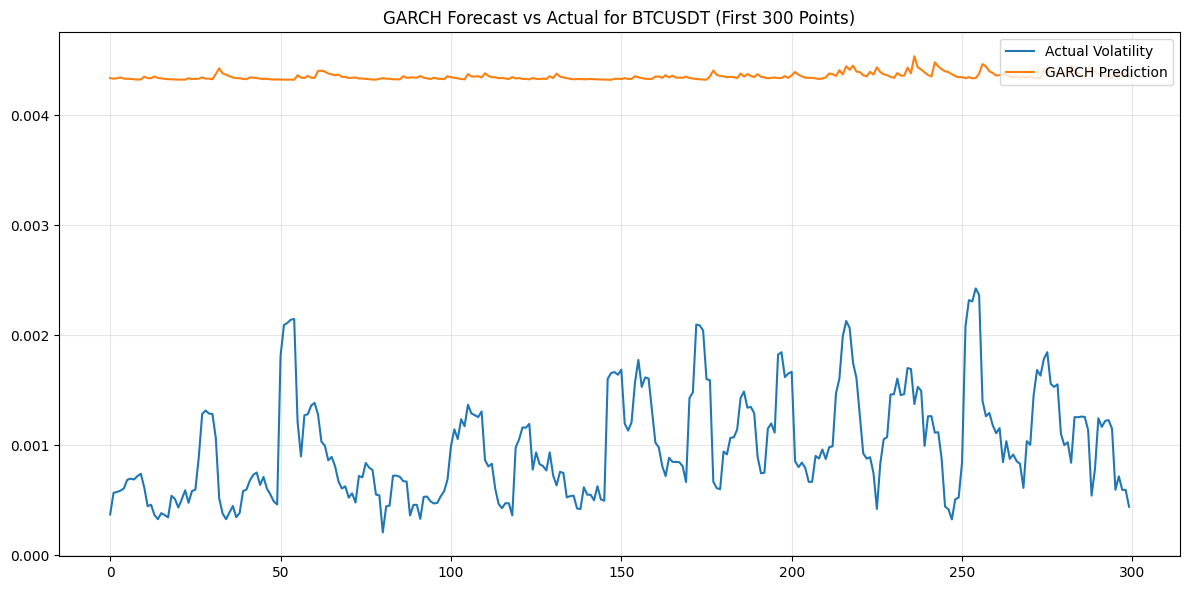

In [52]:
print(f"Plotting BTC Results...")
plot_garch_vs_actual(X_test['rv_fwd_5m'].values, btc_preds, "BTCUSDT", 300)

In [43]:
print(f"{'='*40}\nRUNNING GARCH FOR ETHUSDT\n{'='*40}")

# 1. Get Data Directly from Memory
eth_data = processed_data_store['ETHUSDT']
X_train = eth_data['train']
X_val   = eth_data['val']
X_test  = eth_data['test']

# 2. Stitch Returns (Train + Val + Test)
eth_full_returns = pd.concat([
    X_train['ret_1m'],
    X_val['ret_1m'],
    X_test['ret_1m']
], axis=0)

test_start_index = len(X_train) + len(X_val)

# 3. Fit & Evaluate
eth_garch = garch_model.AutoGARCH(p_max=3, q_max=3)
eth_garch.fit(eth_full_returns, test_start_index=test_start_index)

# Note: The target 'rv_fwd_5m' is in the test dataframe
eth_preds, eth_metrics = eth_garch.evaluate(X_test['rv_fwd_5m'].values, horizon=5)

RUNNING GARCH FOR ETHUSDT
   (Scaling returns by 100 for stability...)
AutoGARCH: Tuning (p=1-3, q=1-3)...


c:\Users\helen\OneDrive\Desktop\GSB - MSQF\2025 Fall\Blockchain, Cryptocurrency, and Algorithmic Trading\workspace\project\garch_model.py:40: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = model.fit(last_obs=test_start_index, disp='off')
c:\Users\helen\OneDrive\Desktop\GSB - MSQF\2025 Fall\Blockchain, Cryptocurrency, and Algorithmic Trading\workspace\project\garch_model.py:40: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = model.fit(last_obs=test_start_index, disp='off')
c:\Users\helen\OneDrive\Desktop\GSB - MSQF\2025 Fall\Blockchain, Cryptocurrency, and Algorithmic Trading\workspace\project\garch_model.py:40: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  re

Best Model: GARCH(1, 3) | BIC: -2576604.63
Generating GARCH Forecasts...

GARCH RESULTS (Test Set):
   RMSE: 0.000897
   MAE:  0.000591
   R^2:  0.395588


In [44]:
# 1. Define Actuals and Predictions 
actuals = X_test['rv_fwd_5m'].values
preds = eth_preds

# 2. Print the first 5 values side-by-side to see the scale mismatch
print(f"{'Index':<5} | {'Actual Vol':<12} | {'Pred Vol':<12} | {'Difference'}")
print("-" * 45)
for i in range(5):
    print(f"{i:<5} | {actuals[i]:.6f}     | {preds[i]:.6f}     | {actuals[i] - preds[i]:.6f}")

# 3. Check the Ratio
mean_actual = np.mean(actuals)
mean_pred = np.mean(preds)
ratio = mean_pred / mean_actual

print("-" * 45)
print(f"Mean Actual: {mean_actual:.6f}")
print(f"Mean Pred:   {mean_pred:.6f}")
print(f"Ratio:       {ratio:.2f}x")

Index | Actual Vol   | Pred Vol     | Difference
---------------------------------------------
0     | 0.000372     | 0.001047     | -0.000675
1     | 0.000569     | 0.001012     | -0.000443
2     | 0.000577     | 0.000971     | -0.000394
3     | 0.000588     | 0.000946     | -0.000357
4     | 0.000608     | 0.000913     | -0.000305
---------------------------------------------
Mean Actual: 0.001624
Mean Pred:   0.001744
Ratio:       1.07x


Plotting ETH Results...


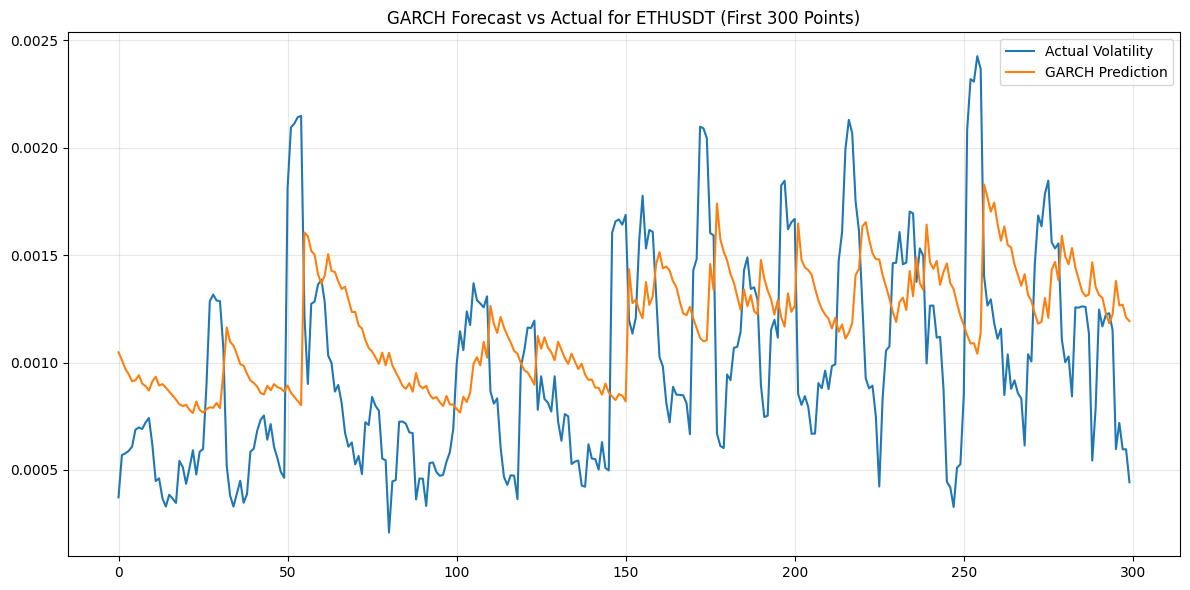

In [54]:
print(f"Plotting ETH Results...")
plot_garch_vs_actual(X_test['rv_fwd_5m'].values, eth_preds, "ETHUSDT", 300)